In [8]:
import matplotlib.pyplot as plt
from cycler import cycler

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    

plt.rc('figure', figsize=(14, 8),titlesize=16)
plt.rc('legend', frameon=True,fancybox=True,fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('grid', linestyle="--", color='grey',alpha = 0.2)
plt.rc('font', size=14, family='sans-serif',style='normal',weight='normal')
plt.rc('axes', labelsize=14, titlesize=14,
       titleweight='bold',prop_cycle=(cycler('color',tableau20)))

In [3]:
import pandas as pd
import numpy as np
import datetime
import os
%matplotlib inline

import matplotlib as mpl
#import seaborn as sns

In [4]:
df = pd.read_pickle(os.path.join('data','quote=FING-BSSAB-B&start=2016-10-03&end=2017-10-02&interval=1440min.pkl'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
datetime    506 non-null datetime64[ns]
stock       506 non-null object
open        506 non-null float64
high        506 non-null float64
low         506 non-null float64
close       506 non-null float64
volume      506 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 27.8+ KB


open           high           low          close  \
stock                FING-B SSAB-B  FING-B SSAB-B FING-B SSAB-B  FING-B   
datetime                                                                  
2016-10-03 17:30:00  101.00  20.90  101.50  21.47  99.30  20.85   99.80   
2016-10-04 17:30:00  100.00  21.30  100.90  21.82  99.00  21.30   99.80   
2016-10-05 17:30:00  100.20  21.68  101.00  21.84  99.25  21.47  100.20   
2016-10-06 17:30:00   99.75  21.85   99.85  21.94  95.25  21.56   96.25   
2016-10-07 17:30:00   97.00  21.80   97.20  22.39  94.10  21.78   95.40   

                                volume             
stock               SSAB-B      FING-B     SSAB-B  
datetime                                           
2016-10-03 17:30:00  21.32   2840234.0  4630179.0  
2016-10-04 17:30:00  21.75   3377179.0  4041791.0  
2016-10-05 17:30:00  21.80   4156429.0  3391308.0  
2016-10-06 17:30:00  21.68  11570839.0  2261553.0  
2016-10-07 17:30:00  22.20   6092416.0  6582477.0

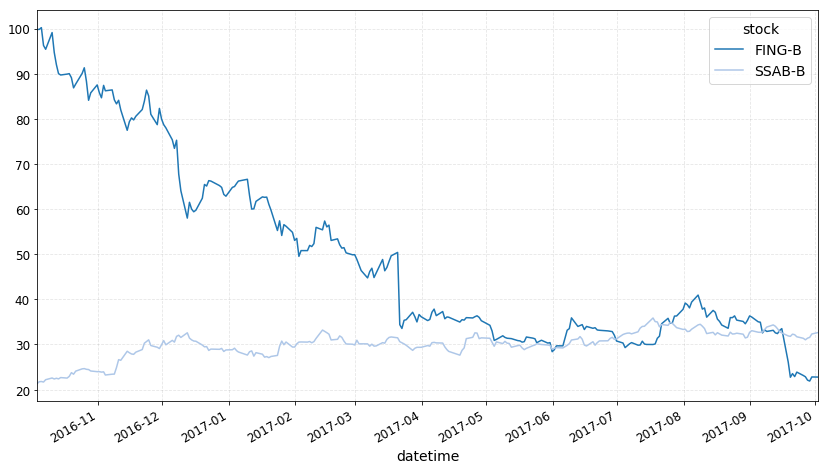

In [9]:
df_stock = df.groupby(['datetime','stock']).sum().unstack()
stocks = df_stock['close'].columns
df_stock['close'].plot(grid=True)
df_stock.head()

In [61]:
# ADD MEASURES
df_stock = df_stock.join(df_stock[['close']].div(df_stock['open']).sub(1).mul(100).rename(columns={'close':'pct_open_close'}))
df_stock = df_stock.join(df_stock[['high']].div(df_stock['low']).sub(1).mul(100).rename(columns={'high':'pct_low_high'}))
df_stock = df_stock.join(df_stock[['high']].div(df_stock['open']).sub(1).mul(100).rename(columns={'high':'pct_open_high'}))
df_stock = df_stock.join(df_stock[['open']].div(df_stock['close'].shift(periods=1)).sub(1).mul(100).rename(columns={'open':'pct_close_open'}))
df_stock = df_stock.join(df_stock[['close']].div(df_stock['close'].shift(periods=1)).sub(1).mul(100).rename(columns={'close':'pct_close_close'}))
df_stock.head()

open           high           low          close  \
stock                FING-B SSAB-B  FING-B SSAB-B FING-B SSAB-B  FING-B   
datetime                                                                  
2016-10-03 17:30:00  101.00  20.90  101.50  21.47  99.30  20.85   99.80   
2016-10-04 17:30:00  100.00  21.30  100.90  21.82  99.00  21.30   99.80   
2016-10-05 17:30:00  100.20  21.68  101.00  21.84  99.25  21.47  100.20   
2016-10-06 17:30:00   99.75  21.85   99.85  21.94  95.25  21.56   96.25   
2016-10-07 17:30:00   97.00  21.80   97.20  22.39  94.10  21.78   95.40   

                                volume            pct_open_close            \
stock               SSAB-B      FING-B     SSAB-B         FING-B    SSAB-B   
datetime                                                                     
2016-10-03 17:30:00  21.32   2840234.0  4630179.0      -1.188119  2.009569   
2016-10-04 17:30:00  21.75   3377179.0  4041791.0      -0.200000  2.112676   
2016-10-05 17:30:00  21.80   4156429.0  3391308.0       0.000000  0.553506   
2016-10-06 17:30:00  21.68  11570839.0  2261553.0      -3.508772 -0.778032   
2016-10-07 17:30:00  22.20   6092416.0  6582477.0      -1.649485  1.834862   

                    pct_low_high           pct_open_high            \
stock                     FING-B    SSAB-B        FING-B    SSAB-B   
datetime                                                             
2016-10-03 17:30:00     2.215509  2.973621      0.495050  2.727273   
2016-10-04 17:30:00     1.919192  2.441315      0.900000  2.441315   
2016-10-05 17:30:00     1.763224  1.723335      0.798403  0.738007   
2016-10-06 17:30:00     4.829396  1.762523      0.100251  0.411899   
2016-10-07 17:30:00     3.294368  2.800735      0.206186  2.706422   

                    pct_close_open           pct_close_close            
stock                       FING-B    SSAB-B          FING-B    SSAB-B  
datetime                                                                
2016-10-03 17:30:00            NaN       NaN             NaN       NaN  
2016-10-04 17:30:00       0.200401 -0.093809        0.000000  2.016886  
2016-10-05 17:30:00       0.400802 -0.321839        0.400802  0.229885  
2016-10-06 17:30:00      -0.449102  0.229358       -3.942116 -0.550459  
2016-10-07 17:30:00       0.779221  0.553506       -0.883117  2.398524

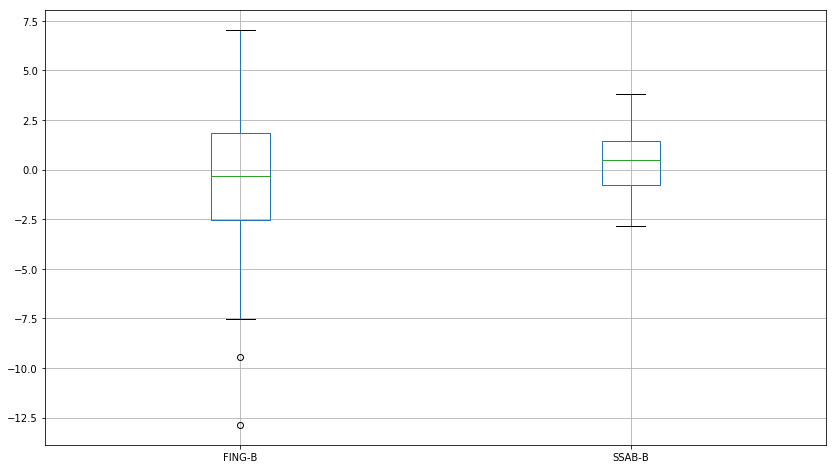

In [101]:
#Q: What happened x days after a y% change?
x_days = 1
pct_change = -2
df_stock['pct_close_close'][(df_stock['pct_close_close']<pct_change).shift(x_days).replace(np.nan,False)].plot(kind='box',grid=True)

0
1


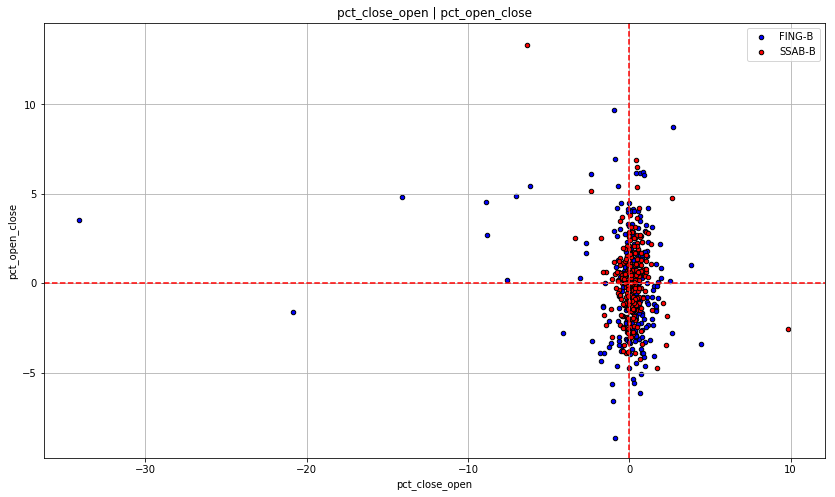

In [103]:
df_stock_swap = df_stock.swaplevel(axis=1)

# CLose price change dependancy
f, ax = plt.subplots(1,1)
x = 'pct_close_open'
y = 'pct_open_close'
colors = ['blue','red']
for nr,stock in enumerate(stocks):
    print(nr)
    df_sel = df_stock_swap[stock]
    df_sel.plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=20,color=colors[nr],edgecolor='black',title=x+' | '+y,legend=True)
ax.legend(stocks)
ax.axhline(0,ls = '--',color='red')
ax.axvline(0,ls = '--',color='red')